### Load in

In [1]:
''' Make sure you have pandorasim installed and updated '''

import pandorasat as ps
import pandorasim as pp
ps.utils.get_phoenix_model(teff=7000, jmag=10) ### this is a temporary fix to an import error with pandorasim
from pandorasim import VisibleSim, NIRSim
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.io import fits
from pandorasat.plotting import animate
from pandorasat.plotting import save_mp4, save_gif
from astropy.time import Time, TimeDelta
from CommissFunctions import generate_task_plan

#### These are commissioning specific functions. 
from CommissFunctions import generate_task_plan

### These are constants that currently don't come from PandoraSat.  
from CommissFunctions import data_rate, bits_per_pix_VIS, compression_fractor_VIS, frame_time_VIS, stored_frames_per_int_VIS, pass_time_min


/Users/lindseywiser/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
''' Define a PandoraSat object for calling constants '''
p = ps.PandoraSat()

# Data Volume

Here, we estimate data volume based on obseravtion parameters and estimated rates and sizes.

In [3]:
''' this sets observing parameters for activity '''
VIS_xpix              = 200 ### saving three 200x200 regions
VIS_ypix              = 200 
regions               = 3  
frames_per_int        = 1
num_int               = 30000 

''' Calculating data volumes '''
int_and_reset_time    = frame_time_VIS * frames_per_int
bits_per_int          = VIS_xpix * VIS_ypix * regions * bits_per_pix_VIS * stored_frames_per_int_VIS
bits_per_sec          = bits_per_int / int_and_reset_time
test_time             = num_int * int_and_reset_time  ### seconds
bits_per_sec_comp     = bits_per_sec / compression_fractor_VIS
bits_test_total       = bits_per_sec_comp * test_time
Gbits_test_packet     = bits_test_total / 1E9 * 1.1 * 1.25
downlinks             = Gbits_test_packet * 1E9 / (data_rate * 1E6) /60 /pass_time_min 

print('test time:', test_time/60/60, 'hours')
print(Gbits_test_packet, 'Gbits')
print(downlinks, 'downlinks')


''' Test reducing temporal resolution for lower data volume. '''
#reduce_by = 1
#print('Reduced Temporal Resolution')
#print(Gbits_test_packet/reduce_by, 'Gbits')
#print(downlinks/reduce_by, 'downlinks')

test time: 1.6666666666666667 hours
52.800000000000004 Gbits
22.000000000000004 downlinks


' Test reducing temporal resolution for lower data volume. '

# Define Target 

For now, we select an arbitrary primary target to place at the center of the frame. The target selection process is being developed (check with Aisha Iyer or Lindsey Wiser). For now, the two secondary targets are the next two brightest objects in frame. 

In [4]:
### Posible Targets:
# ...
# ...
# ...
# ...

In [5]:
''' Finds target coordinates based on astropy '''
### You can do this differently as long as you have DEC and RA
target = "WASP 80"
c = SkyCoord.from_name(target)


''' Identify the start time and end time of the observation '''
start_time = Time.now() 
time_delta = TimeDelta(test_time, format='sec')
end_time = start_time + time_delta


''' Initialize a simulator object '''
### If there are not enough targets that meet Pandora's observable criteria, you will get an error. 
### There is a bug here right now, so you may sometimes get an error even when there are enough targets.
sim = VisibleSim(nROIs=regions, ROI_size=(VIS_xpix, VIS_ypix)) 


''' Point the simulator at the above target '''
###        RA,   DEC,    Theta 
sim.point(c.ra, c.dec, -40*u.deg) 


''' identify the correct ROIs based on pixels '''
### Currently, this is commented out and we're just taking the three default ROIs. But uncomment 
### this when we have specific targets to identify. Targets are identified by pixel location. 
### (924.0, 924.0) is the center.
#sim.ROI_corners = [(924.0, 924.0), (1000, 1500), (500, 1000)]
print('ROI locations [pix]: ', sim.ROI_corners)

Output()

Output()

Output()

Output()

ROI locations [pix]:  [(924.0, 924.0), (1352, 1595), (764, 187)]


In [6]:
''' sim has various attributes you can print out '''
#print(sim.ra, sim.dec, sim.wcs)

''' Notably we have a Catalog of objects visable in the VIS FOV '''
cat = sim.source_catalog
#print(cat)

# Observation

<Axes: title={'center': 'VISDA\n(RA:303.17 deg, Dec:-2.14 deg, Roll:-40.00 deg)'}, xlabel='Column [pixel]', ylabel='Row [pixel]'>

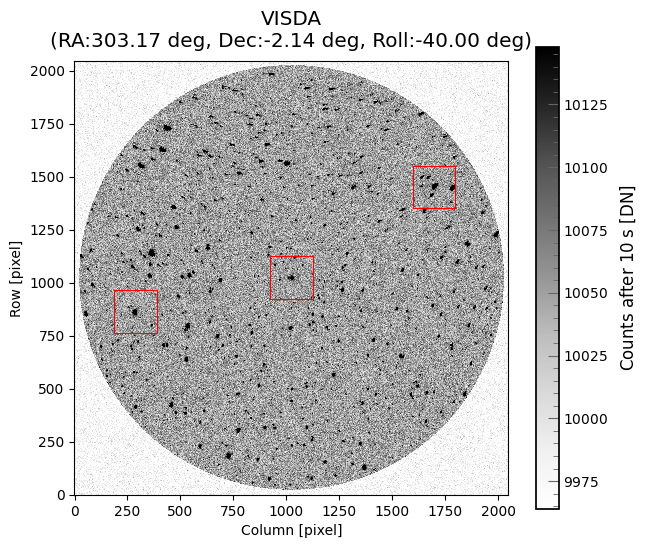

In [7]:
''' Plot the Full Frame Image. ROIs are in red boxes defining the subarray. '''
sim.show_FFI()

In [8]:
''' Create an Observation. '''
### This returns an astropy.io.fits.HDUList array. 
# `nreads` sets how many reads of the detector are coadded together to create a frame.
# `bin_frames` is a shortcut parameter to speed up computation. Must be a factor of nreads. We can ignore this for low nreads. 
# `nframes` sets how many frames will be returned.
# `start_time` indicates the time of observation. 
# `output_type` is set to array, for now. This make it easy to call, but we'll save it as a fits file later. 
###

''' This takes a really long time. For a quick look, reduce nframes by a reduce_factor.'''
reduce_factor = 100
data = sim.observe(nreads=frames_per_int, bin_frames=1, nframes=int(num_int/reduce_factor), start_time=start_time, output_type="array")

### The shape is: (num ROIs, num frames, nrows, ncolumns)
data.shape

Modeling Pixel Positions: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.34it/s]


(3, 300, 200, 200)

array([[<Axes: ylabel='Row\n[subarray pixel]'>, <Axes: >],
       [<Axes: xlabel='Column\n[subarray pixel]', ylabel='Row\n[subarray pixel]'>,
        <Axes: >]], dtype=object)

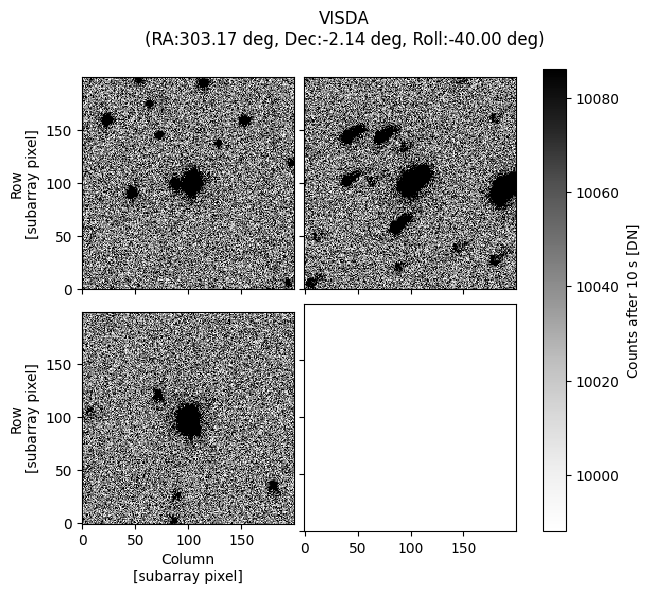

In [9]:
''' Plot our ROIs (regions of interest). ''' 
sim.show_ROI()

In [10]:
''' Plot animations of ROIs frame-to-frame. Adjust index to switch ROIs. ''' 
index = 0
animate(data[index])

### If you want to save this:
#save_mp4(data[index], "3_12_animation.mp4")
#save_gif(data[index], "3_12_animation.gif")

# Save the simulated observation

In [14]:
''' Re-Create the observation in the correct format for the .fits file (i.e., output_type set to default) '''
### Before, object_type was array for easy computation in this notebook, but that is not correct for the .fits file
hdulist = sim.observe(nreads=frames_per_int, nframes=int(num_int/reduce_factor), bin_frames=1, start_time=start_time)


''' Save our simulated observation in a fits file '''
targ = target.replace(" ", "")
rois_outfile = "3_12_rois_"+str(targ)+".fits" ### REMEMBER to change this number for 3.12 or 3.17
hdulist.writeto(rois_outfile, overwrite=True)

Modeling Pixel Positions: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 13.65it/s]


In [15]:
''' Show what is in our fits file: 

FITS file extensions: 
    (1) PRIMARY with some information about the simulated observation 
    (2) SCIENCE with information about the data
    (3) ROIs with information about each ROI 
'''

hdul_rois = fits.open(rois_outfile)
print(hdul_rois.info())

#print('.')
#print('.')
#print('.')
#print('-- PRIMARY Headers --')
#print(hdul_ffis[0].header)

#print('.')
#print('.')
#print('.')
#print('-- SCIENCE Headers --')
#print(hdul_ffis[1].header)

#print('.')
#print('.')
#print('.')
#print('-- ROI Headers --')
#print(hdul_ffis[2].header)

Filename: 3_12_rois_WASP80.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      23   ()      
  1  SCIENCE       1 ImageHDU        75   (400, 400, 300)   int64   
  2  ROITABLE      1 BinTableHDU     24   2R x 3C   [D, K, K]   
None


# Check pass threshold

The data should measure the pointing accuracy (absolute) and precision (rms variation from nominal) in arcseconds over time. Measure jitter from expected location. 

Right now, we aren't including much here, but we can develop this further if it would be useful. 

Text(0.5, 1.0, 'Integration 0')

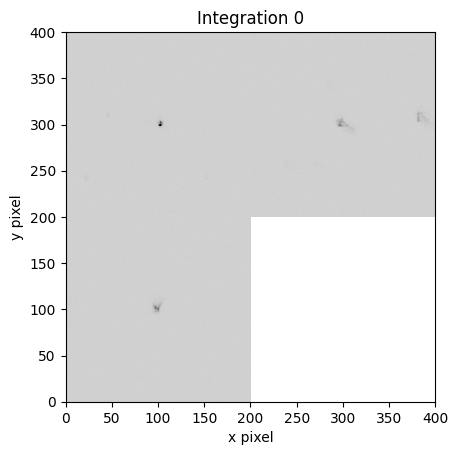

In [17]:
''' Plot the ROIs from the fits file to compare to expected target locations '''

frame = 0 ### specify which integration to plot 
image = hdul_rois[1].data[frame]

### pixel numbers do not correlate with detector pixel numbers here.
plt.imshow(image, cmap='binary', interpolation='nearest', extent=[0, VIS_xpix*2, 0, VIS_ypix*2])

plt.xlabel('x pixel')
plt.ylabel('y pixel')
plt.title('Integration '+str(frame))

# Generate SOC File

In [18]:
'''Here we define the information required for scheduling the observation.'''
### Some of this may change. There are some variables I'm working to understand. 

variables = {
    'visit_id': '0312', ### setting based on task number. Could change. 
    'obs_id': '000', ### this adjusts for tasks with multiple observations
    'target': target, 
    'priority': '1', 
    'start_time': str(start_time), 
    'stop_time': str(end_time), 
    'RA': str(c.ra),
    'DEC': str(c.dec), 
    'NIR_AvgGroups': '0', ### no NIR. 
    'NIR_ROI_StartX': '0', 
    'NIR_ROI_StartY': '0', 
    'NIR_ROI_SizeX': '0', 
    'NIR_ROI_SizeY': '0',
    'NIR_SC_Resets1': '0',
    'NIR_SC_Resets2': '0', 
    'NIR_SC_DropFrames1': '0',
    'NIR_SC_DropFrames2': '0',
    'NIR_SC_DropFrames3': '0', 
    'NIR_SC_ReadFrames': '0',
    'NIR_targetID': '', 
    'NIR_SC_Groups': '0',
    'NIR_SC_Integrations': '0', 
    'VIS_StartRoiDetMethod': '0',  ### what is this?
    'VIS_FramesPerCoadd': str(frames_per_int), 
    'VIS_NumTotalFramesRequested': str(num_int), 
    'VIS_TargetRA': str(c.ra), 
    'VIS_TargetDEC': str(c.dec), 
    'VIS_IncludeFieldSolnsInResp': '1', ### what is this?
    'VIS_StarRoiDimension': str(VIS_xpix), 
    'VIS_MaxNumStarRois': str(regions), ### what is this?
    'VIS_numPredefinedStarRois': '1', ### what is this?
    'VIS_PredefinedStarRoiRa': str(c.ra), 
    'VIS_PredefinedStarRoiDec': str(c.dec), 
    'VIS_targetID': target, #same as target?
    'VIS_NumExposuresMax': str(num_int), ### what is this?
    'VIS_ExposureTime_us':str(frame_time_VIS * 1000000)  
}

In [19]:
'''Generate the SOC .xml file'''
### This may also change format

output_soc_file = '3_12_'+variables['visit_id']+'_'+variables['obs_id']+'_SOC.xml' 
generate_task_plan(variables, output_soc_file)